# Actor Genre Stats Classification
* Using the celebrity filmography history, we compared the type of movie genres the actor performed 
in as measurement to finding similar celebrities with the same genre history.  
* There are 15 top genre that movies are classifed in.
* A movie can be classified into multipe genres.
* For ever movie a celebrity performed in, we assign a count for each movie genre the movie was labeled.
* The total genre count is then normalized based on the total number of movies.

In [1]:
# Configure Environment 
from  tst.data.settings import * 
print("Platform: " , PLATFORM)
print("Data directory : ", os.getcwd())


Platform:  dev
Data directory :  /home/jovyan/dev/data


In [2]:
import math
import os
import os.path
from pprint import pprint
import pickle
import pandas as pd
import json
from collections import defaultdict

In [3]:
genre_map = {99: 'Documentary',
 80: 'Crime',
 18: 'Drama',
 10749: 'Romance',
 35: 'Comedy',
 53: 'Thriller/Mystery',
 9648: 'Thriller/Mystery',
 12: 'Action/Adventure',
 878: 'Science Fiction/Fantasy',
 16: 'Animation',
 10751: 'Family',
 14: 'Science Fiction/Fantasy',
 28: 'Action/Adventure',
 27: 'Horror',
 10752: 'History/War',
 36: 'History/War',
 10770: 'TV Movie',
 10402: 'Music',
 37: 'Western'}

In [4]:
genre_names = list(set(genre_map.values()))

### Load data from themoviedb.org to get the list of casting role each celebrity performed in.

In [5]:
path_to_json = "./person/themoviedb/"
json_files = [path_to_json+pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json') and os.stat(path_to_json+pos_json).st_size>0]
len(json_files)


d = len(genre_names)
genre_counts = {}
for f in json_files:
    data = json.load(open(f))
    if type(data["cast"]) == dict:
        cast = data["cast"]["cast"]
    else:
        cast = data["cast"]
    gc = defaultdict(int)
    for x in cast:
        for g in x["genre_ids"]:
            gc[g] += 1
    total = sum(gc.values())
    vec = [0] * d
    for i, val in gc.items():
        vec[genre_names.index(genre_map[i])] += val
    for i in range(len(vec)): vec[i] /= total
    genre_counts[data["_actorID"]] = {}
    genre_counts[data["_actorID"]]["vec"] = vec
    genre_counts[data["_actorID"]]["name"] = data["name"]
    

## The genre stats is then vectorized and saved as a pickle file to be loaded in Elasticsearch

In [6]:
print( " Shape : ", len(genre_counts), ',', len(genre_names))
pickle.dump( genre_counts,  open( "./models/genreStats.pkl", "wb" ) )
genre_counts = pickle.load( open( './models/genreStats.pkl', 'rb' ) )
genre_counts['1']

 Shape :  100 , 15


{'vec': [0.037037037037037035,
  0.018518518518518517,
  0.0,
  0.0,
  0.0,
  0.0,
  0.4074074074074074,
  0.018518518518518517,
  0.0,
  0.037037037037037035,
  0.18518518518518517,
  0.18518518518518517,
  0.037037037037037035,
  0.0,
  0.07407407407407407],
 'name': 'Robert Downey Jr.'}

In [7]:
# Copy models up to S3 bucket
bucket = os.popen('aws ssm get-parameter --name jupyterBucketName-' + PLATFORM + ' --with-decryption | jq -r .Parameter.Value').read()
print(bucket)
executable = 'aws s3 sync ./models/ s3://' + bucket.strip() + '/models/ '
print(executable)
myCmd = os.popen(executable).read()
print(myCmd)

gary-celebrity-content-dev-vpc-08172c22ced39d93c

aws s3 sync ./models/ s3://gary-celebrity-content-dev-vpc-08172c22ced39d93c/models/ 
Completed 17.8 KiB/17.8 KiB (654.9 KiB/s) with 1 file(s) remaining
upload: models/genreStats.pkl to s3://gary-celebrity-content-dev-vpc-08172c22ced39d93c/models/genreStats.pkl



## Test Elasticsearch to store the vertor and peform cosine similarity score.


In [8]:
import requests
from pprint import pprint
from pprint import pprint
from datetime import datetime
from elasticsearch import Elasticsearch
import json


es= Elasticsearch([{'host':ESHOST,'port':ESPORT}])

_index='genrestats'
_doc= 'genrestats'
esIndex = 'http://'+ESHOST+':'+ESPORT+'/'+_index  
headers={"Content-Type": "application/json"}

In [9]:
d= len( genre_counts['1']['vec'])
request_body = {
  "mappings": {
    "properties": {
      "_actorID" : {
        "type" : "keyword"
      },     
      "genre_vector": {
        "type": "dense_vector",
        "dims": d
      }

    }
  }
}

try:
    es.indices.delete(index = _index)
except:
    pass
    
es.indices.create(index = _index, body = request_body)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'genrestats'}

In [10]:
esIndex

'http://elasticsearch-dev.ocp.bdso.salientcrgt-bdso.com:80/genrestats'

In [11]:
for i, d in genre_counts.items():
    _id = str(i)
    print(_id)
    doc = {
        "_actorID" : _id,
        "genre_vector": d["vec"], 
        "celebrity" : d["name"]
        }
    print(doc)
    r = requests.put(esIndex+'/_doc/'+_id, headers= headers, data = json.dumps(doc))
    
    print (r.text)

1
{'_actorID': '1', 'genre_vector': [0.037037037037037035, 0.018518518518518517, 0.0, 0.0, 0.0, 0.0, 0.4074074074074074, 0.018518518518518517, 0.0, 0.037037037037037035, 0.18518518518518517, 0.18518518518518517, 0.037037037037037035, 0.0, 0.07407407407407407], 'celebrity': 'Robert Downey Jr.'}
{"_index":"genrestats","_type":"_doc","_id":"1","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":0,"_primary_term":1}
8
{'_actorID': '8', 'genre_vector': [0.12643678160919541, 0.011494252873563218, 0.0, 0.0, 0.04597701149425287, 0.011494252873563218, 0.3333333333333333, 0.0, 0.0, 0.034482758620689655, 0.19540229885057472, 0.05747126436781609, 0.10344827586206896, 0.0, 0.08045977011494253], 'celebrity': 'Chris Hemsworth'}
{"_index":"genrestats","_type":"_doc","_id":"8","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":1,"_primary_term":1}
11
{'_actorID': '11', 'genre_vector': [0.05333333333333334, 0.013333333333333334

{"_index":"genrestats","_type":"_doc","_id":"19","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":19,"_primary_term":1}
17
{'_actorID': '17', 'genre_vector': [0.02564102564102564, 0.02564102564102564, 0.02564102564102564, 0.0, 0.05128205128205128, 0.0, 0.38461538461538464, 0.0, 0.0, 0.02564102564102564, 0.1794871794871795, 0.15384615384615385, 0.07692307692307693, 0.0, 0.05128205128205128], 'celebrity': 'Don Cheadle'}
{"_index":"genrestats","_type":"_doc","_id":"17","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":20,"_primary_term":1}
16
{'_actorID': '16', 'genre_vector': [0.16666666666666666, 0.018518518518518517, 0.0, 0.0, 0.018518518518518517, 0.018518518518518517, 0.2962962962962963, 0.018518518518518517, 0.0, 0.07407407407407407, 0.12962962962962962, 0.07407407407407407, 0.037037037037037035, 0.0, 0.14814814814814814], 'celebrity': 'Jeremy Renner'}
{"_index":"genrestats","_type":"_doc","_id":"16","_

{"_index":"genrestats","_type":"_doc","_id":"60","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":43,"_primary_term":1}
84
{'_actorID': '84', 'genre_vector': [0.0, 0.028985507246376812, 0.08695652173913043, 0.0, 0.0, 0.043478260869565216, 0.15942028985507245, 0.0, 0.11594202898550725, 0.014492753623188406, 0.057971014492753624, 0.10144927536231885, 0.2463768115942029, 0.08695652173913043, 0.057971014492753624], 'celebrity': 'Jack Black'}
{"_index":"genrestats","_type":"_doc","_id":"84","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":44,"_primary_term":1}
30
{'_actorID': '30', 'genre_vector': [0.12987012987012986, 0.0, 0.0, 0.025974025974025976, 0.012987012987012988, 0.0, 0.2857142857142857, 0.03896103896103896, 0.0, 0.07792207792207792, 0.07792207792207792, 0.06493506493506493, 0.11688311688311688, 0.0, 0.16883116883116883], 'celebrity': 'Josh Brolin'}
{"_index":"genrestats","_type":"_doc","_id":"30","_v

{"_index":"genrestats","_type":"_doc","_id":"38","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":66,"_primary_term":1}
37
{'_actorID': '37', 'genre_vector': [0.09259259259259259, 0.037037037037037035, 0.009259259259259259, 0.0, 0.07407407407407407, 0.009259259259259259, 0.18518518518518517, 0.027777777777777776, 0.027777777777777776, 0.046296296296296294, 0.10185185185185185, 0.06481481481481481, 0.05555555555555555, 0.037037037037037035, 0.23148148148148148], 'celebrity': 'Benedict Cumberbatch'}
{"_index":"genrestats","_type":"_doc","_id":"37","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":67,"_primary_term":1}
39
{'_actorID': '39', 'genre_vector': [0.0425531914893617, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06382978723404255, 0.0425531914893617, 0.0851063829787234, 0.06382978723404255, 0.0851063829787234, 0.0851063829787234, 0.3191489361702128, 0.10638297872340426, 0.10638297872340426], 'celebrity': 'Cameron Diaz

{"_index":"genrestats","_type":"_doc","_id":"47","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":88,"_primary_term":1}
57
{'_actorID': '57', 'genre_vector': [0.10344827586206896, 0.034482758620689655, 0.034482758620689655, 0.0, 0.0, 0.0, 0.3448275862068966, 0.0, 0.0, 0.034482758620689655, 0.20689655172413793, 0.0, 0.06896551724137931, 0.0, 0.1724137931034483], 'celebrity': 'Letitia Wright'}
{"_index":"genrestats","_type":"_doc","_id":"57","_version":1,"result":"created","_shards":{"total":2,"successful":2,"failed":0},"_seq_no":89,"_primary_term":1}
64
{'_actorID': '64', 'genre_vector': [0.05405405405405406, 0.02702702702702703, 0.02702702702702703, 0.0, 0.02702702702702703, 0.0, 0.05405405405405406, 0.0, 0.08108108108108109, 0.02702702702702703, 0.08108108108108109, 0.1891891891891892, 0.24324324324324326, 0.10810810810810811, 0.08108108108108109], 'celebrity': 'Mike Myers'}
{"_index":"genrestats","_type":"_doc","_id":"64","_version":1,"result"

In [12]:
r = requests.get(esIndex+'/_doc/1')
pprint(r.text)

('{"_index":"genrestats","_type":"_doc","_id":"1","_version":1,"_seq_no":0,"_primary_term":1,"found":true,"_source":{"_actorID": '
 '"1", "genre_vector": [0.037037037037037035, 0.018518518518518517, 0.0, 0.0, '
 '0.0, 0.0, 0.4074074074074074, 0.018518518518518517, 0.0, '
 '0.037037037037037035, 0.18518518518518517, 0.18518518518518517, '
 '0.037037037037037035, 0.0, 0.07407407407407407], "celebrity": "Robert Downey '
 'Jr."}}')


In [13]:
vec = json.loads(r.text)["_source"]["genre_vector"]
q={
   "_source": {
        "includes": [ "celebrity"]
        },
  "query": {
    "script_score": {

      "query" : {
        "match_all" : {}
      },
      "script": {
        "source": "cosineSimilarity(params.query_vector, doc['genre_vector']) + 1.0", 
        "params": {
          "query_vector": vec
        }
      }
    }
  }
}

res= es.search(index=_index, body=q)

pprint(res)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': '1',
                    '_index': 'genrestats',
                    '_score': 2.0,
                    '_source': {'celebrity': 'Robert Downey Jr.'},
                    '_type': '_doc'},
                   {'_id': '11',
                    '_index': 'genrestats',
                    '_score': 1.988556,
                    '_source': {'celebrity': 'Chris Evans'},
                    '_type': '_doc'},
                   {'_id': '17',
                    '_index': 'genrestats',
                    '_score': 1.9853089,
                    '_source': {'celebrity': 'Don Cheadle'},
                    '_type': '_doc'},
                   {'_id': '41',
                    '_index': 'genrestats',
                    '_score': 1.9703029,
                    '_source': {'celebrity': 'Gwyneth Paltrow'},
                    '_type': '_doc'},
                   {'_id': '2',
                    '_index'

# Cluster Validationusing KMeans 

In [14]:
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import matplotlib.pyplot as plt

In [15]:
genre_counts

{'1': {'vec': [0.037037037037037035,
   0.018518518518518517,
   0.0,
   0.0,
   0.0,
   0.0,
   0.4074074074074074,
   0.018518518518518517,
   0.0,
   0.037037037037037035,
   0.18518518518518517,
   0.18518518518518517,
   0.037037037037037035,
   0.0,
   0.07407407407407407],
  'name': 'Robert Downey Jr.'},
 '8': {'vec': [0.12643678160919541,
   0.011494252873563218,
   0.0,
   0.0,
   0.04597701149425287,
   0.011494252873563218,
   0.3333333333333333,
   0.0,
   0.0,
   0.034482758620689655,
   0.19540229885057472,
   0.05747126436781609,
   0.10344827586206896,
   0.0,
   0.08045977011494253],
  'name': 'Chris Hemsworth'},
 '11': {'vec': [0.05333333333333334,
   0.013333333333333334,
   0.0,
   0.0,
   0.0,
   0.0,
   0.37333333333333335,
   0.05333333333333334,
   0.013333333333333334,
   0.02666666666666667,
   0.18666666666666668,
   0.13333333333333333,
   0.06666666666666667,
   0.0,
   0.08],
  'name': 'Chris Evans'},
 '72': {'vec': [0.15384615384615385,
   0.0,
   0.0,
  

In [16]:
X = np.array([x["vec"] for x in genre_counts.values()])

In [18]:
clust = KMeans().fit(X)

In [19]:
clust.labels_

array([0, 7, 0, 3, 7, 3, 4, 5, 1, 0, 6, 1, 1, 4, 1, 1, 3, 2, 2, 5, 0, 7,
       5, 4, 2, 0, 7, 5, 1, 1, 1, 4, 7, 6, 4, 4, 4, 7, 3, 7, 2, 1, 3, 5,
       4, 7, 2, 7, 1, 7, 4, 1, 3, 7, 7, 3, 3, 3, 1, 3, 1, 5, 0, 5, 7, 1,
       5, 3, 4, 2, 4, 3, 7, 1, 7, 3, 7, 3, 1, 7, 0, 1, 1, 1, 5, 2, 6, 0,
       3, 7, 2, 0, 5, 3, 5, 1, 3, 6, 7, 5], dtype=int32)

In [20]:
ids = list(genre_counts.keys())

In [21]:
for c in range(max(clust.labels_)):
    c_actors = [i for i in range(len(clust.labels_)) if clust.labels_[i] == c]
    c_ids = [ids[i] for i in c_actors]
    c_names = [genre_counts[i]["name"] for i in c_ids]
    print(c_names)
    print("\n")

['Robert Downey Jr.', 'Chris Evans', 'Vin Diesel', 'Don Cheadle', 'Chadwick Boseman', 'Dave Bautista', 'Gwyneth Paltrow', 'Paul Bettany', 'Tom Cruise']


['Daisy Ridley', 'John Boyega', 'Mark Ruffalo', 'Johnny Depp', 'Tom Hiddleston', 'Mark Hamill', 'Emma Watson', 'Will Smith', 'Jennifer Lawrence', 'Scarlett Johansson', 'Carrie Fisher', 'Karen Gillan', 'Hugh Jackman', 'Jon Favreau', 'Martin Freeman', 'Ian McKellen', 'Simon Pegg', 'Rupert Grint', 'Chris Pratt', 'Chris Pine']


['Dustin Hoffman', 'Steve Martin', 'Tim Allen', 'Robin Williams', 'Jim Carrey', 'Tom Hanks', 'Meryl Streep', 'Mike Myers']


['Shia LaBeouf', 'Taylor Lautner', 'Bradley Cooper', 'Mark Wahlberg', 'Brad Pitt', 'Daniel Radcliffe', 'Sandra Bullock', 'Reese Witherspoon', 'Robert De Niro', 'Adam Driver', 'Benedict Cumberbatch', 'Pom Klementieff', 'Nicole Kidman', 'Kristen Stewart', 'Julia Roberts', 'Natalie Portman', 'Christian Bale']


['Eddie Murphy', 'Bill Murray', 'Will Ferrell', 'Steve Carell', 'Ben Stiller', 'Adam

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
PCA = pd.DataFrame(pca_2d)


<Figure size 432x288 with 0 Axes>

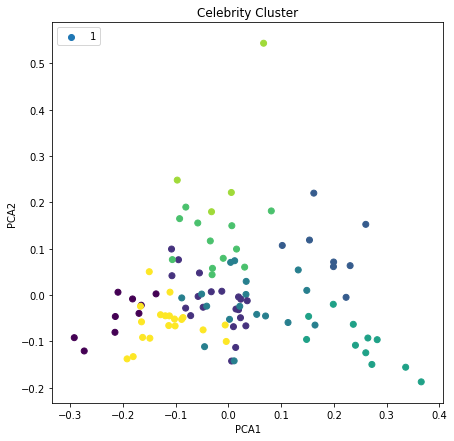

In [23]:
plt.figure('Celebrity Cluster')
plt.figure(figsize = (7,7))
plt.scatter(PCA[0], PCA[1], c=clust.labels_)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Celebrity Cluster')
plt.legend(loc='upper left')
plt.show()